# Uniform Radius

Reached jamming limit with fixed-radius inclusions.
Highest VF Possible with Static Inclusions (No Shaking) of Fixed Size: 0.5462


C:\Users\dhrub\AppData\Local\Temp\ipykernel_36540\436255087.py:91: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x, y), r, color='blue', alpha=0.6, edgecolor='none')


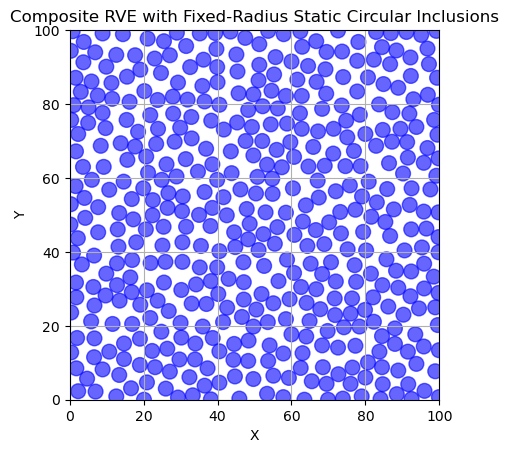

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point, box

# Parameters
grid_size = 100  # Size of the RVE bounding box (100x100 grid)
target_volume_fraction = 0.6  # Target volume fraction for inclusions
spacing = 0.1  # Spacing between candidate points (adjustable)

# Fixed radius for initial inclusions
inclusion_radius = 2  # Radius of each inclusion

# Create a list of candidate points with specified spacing
x_coords = np.arange(0, grid_size, spacing)
y_coords = np.arange(0, grid_size, spacing)
distance_to_nearest = np.full((len(x_coords), len(y_coords)), np.inf)
inclusion_centers = []

def calculate_inclusion_area(radius):
    return np.pi * (radius ** 2)

def calculate_partial_area_within_boundary(x, y, radius, grid_size):
    circle = Point(x, y).buffer(radius)
    bounding_box = box(0, 0, grid_size, grid_size)
    return circle.intersection(bounding_box).area

total_area = grid_size ** 2
running_area_covered = 0.0

# Estimate how many fixed-radius inclusions you'd need
estimated_area = calculate_inclusion_area(inclusion_radius)
required_inclusions = int(target_volume_fraction * total_area / estimated_area)

def update_distances(new_center_idx, radius):
    x_idx, y_idx = new_center_idx
    x = x_coords[x_idx]; y = y_coords[y_idx]
    delta = int(2 * radius / spacing) + 1
    x_min = max(0, x_idx - delta)
    x_max = min(len(x_coords), x_idx + delta)
    y_min = max(0, y_idx - delta)
    y_max = min(len(y_coords), y_idx + delta)

    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            dx = x_coords[i] - x
            dy = y_coords[j] - y
            dist = np.hypot(dx, dy)
            if dist <= radius:
                distance_to_nearest[i, j] = 0
            else:
                distance_to_nearest[i, j] = min(distance_to_nearest[i, j], dist - radius)

def place_inclusion(radius):
    valid_pts = np.argwhere(distance_to_nearest >= radius)
    if valid_pts.size == 0:
        raise ValueError("No more valid positions available.")
    sel = valid_pts[random.randint(0, len(valid_pts) - 1)]
    x_idx, y_idx = sel
    x, y = x_coords[x_idx], y_coords[y_idx]
    inclusion_centers.append((x, y, radius))
    update_distances((x_idx, y_idx), radius)

# --- Fixed-radius placement only ---
for _ in range(required_inclusions):
    try:
        place_inclusion(inclusion_radius)
    except ValueError:
        print("Reached jamming limit with fixed-radius inclusions.")
        break

    # update running covered area
    x, y, r = inclusion_centers[-1]
    running_area_covered += calculate_partial_area_within_boundary(x, y, r, grid_size)

    if running_area_covered / total_area >= target_volume_fraction:
        print("Target volume fraction reached during fixed-radius placement.")
        break

# Final report
final_vf = running_area_covered / total_area
print(f"Highest VF Possible with Static Inclusions (No Shaking) of Fixed Size: {final_vf:.4f}")

# Visualization
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)

for x, y, r in inclusion_centers:
    circle = plt.Circle((x, y), r, color='blue', alpha=0.6, edgecolor='none')
    ax.add_artist(circle)

plt.title("Composite RVE with Fixed-Radius Static Circular Inclusions")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

# Variable Radius

No spacious grid points left for fixed-radius inclusions. Will add smaller inclusions now.
No more space to place additional inclusions.
Final Volume Fraction: 0.9290


C:\Users\dhrub\AppData\Local\Temp\ipykernel_36540\801381473.py:118: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x, y), radius, color='blue', alpha=0.6, edgecolor='none')


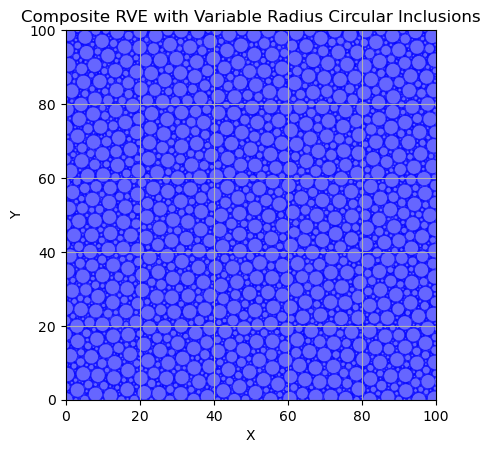

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point, box

# Parameters
grid_size = 100  # Size of the RVE bounding box (100x100 grid)
# I think the target_volume_fraction will be ignored in this code.
target_volume_fraction = 0.8  # Target volume fraction for inclusions
spacing = 0.1  # Spacing between candidate points (adjustable)

# Fixed radius for initial inclusions
inclusion_radius = 2  # Radius of each inclusion

# Create a list of candidate points with specified spacing
x_coords = np.arange(0, grid_size, spacing)
y_coords = np.arange(0, grid_size, spacing)
distance_to_nearest = np.full((len(x_coords), len(y_coords)), np.inf)  # Initialize distances to infinity
inclusion_centers = []

def calculate_inclusion_area(radius):
    """Calculate area of a circular inclusion given its radius."""
    return np.pi * (radius ** 2)

def calculate_partial_area_within_boundary(x, y, radius, grid_size):
    """Calculate the area of a circle within the RVE boundary if it protrudes."""
    circle = Point(x, y).buffer(radius)  # Create a circular inclusion
    bounding_box = box(0, 0, grid_size, grid_size)  # Define the RVE bounding box
    intersection = circle.intersection(bounding_box)  # Calculate intersection area
    return intersection.area  # Return area within bounds

# Calculate total area and estimate the initial required inclusions
total_area = grid_size ** 2
estimated_inclusion_area = calculate_inclusion_area(inclusion_radius)
required_inclusions = int(target_volume_fraction * total_area / estimated_inclusion_area)

def update_distances(new_center_idx, radius):
    """Efficiently update the distance array for points near the new inclusion with a given radius."""
    x_idx, y_idx = new_center_idx
    x = x_coords[x_idx]
    y = y_coords[y_idx]
    
    # Define a bounding box around the new inclusion for localized updates
    x_min = max(0, x_idx - int(2 * radius / spacing))
    x_max = min(len(x_coords), x_idx + int(2 * radius / spacing) + 1)
    y_min = max(0, y_idx - int(2 * radius / spacing))
    y_max = min(len(y_coords), y_idx + int(2 * radius / spacing) + 1)
    
    # Update distances only within the bounding box
    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            dist_to_center = np.sqrt((x_coords[i] - x) ** 2 + (y_coords[j] - y) ** 2)
            if dist_to_center <= radius:
                distance_to_nearest[i, j] = 0  # Mark as within the inclusion
            else:
                dist_to_circumference = dist_to_center - radius
                if dist_to_circumference < distance_to_nearest[i, j]:
                    distance_to_nearest[i, j] = dist_to_circumference

def place_inclusion(radius):
    """Place a new inclusion at a random valid grid point with the specified radius."""
    # Get all grid points with enough space around them (distance >= radius)
    valid_points = np.argwhere(distance_to_nearest >= radius)
    
    if len(valid_points) == 0:
        raise ValueError("No more valid positions available to place inclusions with this radius.")
    
    # Select a random point from valid points
    selected_idx = valid_points[random.randint(0, len(valid_points) - 1)]
    x_idx, y_idx = selected_idx
    x, y = x_coords[x_idx], y_coords[y_idx]
    
    # Add inclusion center and update distances
    inclusion_centers.append((x, y, radius))
    update_distances((x_idx, y_idx), radius)


# Step 1: Place fixed-radius inclusions until reaching the jamming limit
for _ in range(required_inclusions):
    try:
        place_inclusion(inclusion_radius)
    except ValueError:
        print("No spacious grid points left for fixed-radius inclusions. Will add smaller inclusions now.")
        break

# Step 2: Enter greedy mode to fill remaining space with variable-radius inclusions
while True:
    # Find the grid point with the maximum space around it
    max_dist_idx = np.unravel_index(np.argmax(distance_to_nearest), distance_to_nearest.shape)
    max_distance = distance_to_nearest[max_dist_idx]
    
    # If the maximum distance is too small, stop the greedy placement
    if max_distance < spacing:
        print("No more space to place additional inclusions.")
        break
    
    # Place the largest possible inclusion at this point
    place_inclusion(max_distance)


# Calculate the actual area covered by inclusions within the bounding box
actual_area_covered = sum(
    calculate_partial_area_within_boundary(x, y, radius, grid_size)
    for x, y, radius in inclusion_centers
)
final_volume_fraction = actual_area_covered / total_area
#print(f"Target Volume Fraction: {target_volume_fraction}")
print(f"Final Volume Fraction: {final_volume_fraction:.4f}")

# Visualization
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)

# Draw inclusions
for (x, y, radius) in inclusion_centers:
    circle = plt.Circle((x, y), radius, color='blue', alpha=0.6, edgecolor='none')
    ax.add_artist(circle)

plt.title("Composite RVE with Variable Radius Circular Inclusions")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()
